In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch.nn.functional as F
import torch
from torch import nn, optim
from lib.torch_util import *

In [2]:
df = pd.read_csv('colloquial-indonesian-lexicon.csv')

In [3]:
df.columns

Index(['slang', 'formal', 'In-dictionary', 'context', 'category1', 'category2',
       'category3'],
      dtype='object')

In [4]:
group = ['slang', 'formal', 'category1']
df_group = df.groupby(group).agg('count').reset_index()[group]
X = df_group['slang']
y = df_group['formal']
SOS_TOKEN = 0
EOS_TOKEN = 1
PAD_TOKEN = ord('*')

In [5]:
max_len_slang = X.apply(len).max()
max_len_formal = y.apply(len).max()
print('max_len_slang: {}, max_len_formal {}'.format(max_len_slang, max_len_formal))

max_len_slang: 59, max_len_formal 22


In [6]:
X = to_list_of_int(X, max_len_slang)
y = to_list_of_int(y, max_len_slang)

In [7]:
X_train, X_test, X_val, y_train, y_test, y_val = split_train_test_val(
    X, y
)

In [8]:
import logging as log
logger = log.getLogger()
logger.setLevel(log.INFO)

In [9]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=42)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        # make into 1x1 dimension
        embedded = self.embedding(input).view(1, 1, -1)
        
        # gru or other RNN will output: output, hidden layer
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
    def init_hidden(self, device=device):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [10]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, vocab_size, dropout_p = 0.1, max_length=61):
        super(AttnDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length
        self.dropout_p = dropout_p
        
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=42)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden, eo):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        log.info('hidden shape: {}'.format(hidden.shape))
        log.info('embedded shape: {}'.format(embedded.shape))
        attn_weights = F.softmax(
            self.attn(
                torch.cat( (embedded[0], hidden[0]), 1)
            ),
            dim=1
        )
        log.info('attention weight shape: {}'.format(attn_weights.shape))
        log.info('encoder output shape: {}'.format(eo.shape))
        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0)
            , eo.unsqueeze(0)
        )
        log.info('attn applied shape: {}'.format(attn_applied.shape))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden, attn_weights
    
    def init_hidden(self, device=device):
        return torch.zeros(1,1, self.hidden_size, device=device)
        

In [11]:
input_size = max_len_slang + 1
vocab_size = 122 + 2 #include eos and sos
embed_dim = max_len_slang + 1
hidden_size = 256
output_size = max_len_slang + 1
e = Encoder(vocab_size, hidden_size)
d = AttnDecoder(hidden_size, vocab_size)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
eoptimizer = optim.Adam(e.parameters())
doptimizer = optim.Adam(d.parameters())


In [12]:
def train(input_tensor, target_tensor, e, d, eop, dop, criterion, max_length=61):
    eh = e.init_hidden()
    eop.zero_grad()
    dop.zero_grad()
    
    input_length = input_tensor.size(0)
    output_length = target_tensor.size(0)
    
    eoutputs = torch.zeros(max_length, e.hidden_size)
    loss = 0
    
    for ei in range(input_length):
        eo, eh = e(input_tensor[ei], eh)
        eoutputs[ei] = eo[0,0]
    
    # use only last context from encoder
    dh = eh
    dout = []
    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)
    for di in range(output_length):
        do, dh, da = d(decoder_input, dh, eoutputs)
        topv, topi = do.topk(1)
        decoder_input = topi.squeeze().detach()
        dout.append(decoder_input)
        log.info('predicted: {}, char: {}'.format(decoder_input, chr(decoder_input)))
        loss += criterion(do, target_tensor[di].view(1))
    loss.backward()
    eop.step()
    dop.step()
#     ----------------------------------------
    input_length = input_tensor.shape[0]

    eh = e.init_hidden()

    eoutputs = torch.zeros(max_length, e.hidden_size, device=device)

    for ei in range(input_length):
        eo, eh = e(input_tensor[ei],  eh)
        eoutputs[ei] = eo[0,0]

    dinput = torch.tensor([[SOS_TOKEN]], device=device)

    doutputs = []
    dh = eh
    for di in range(max_length):
        do, dh, da = d(dinput, dh, eoutputs)
        topv, topi = do.topk(1)
        char_i = topi.squeeze().detach()
        doutputs.append(char_i)
    
    return loss.item() / max_length
        
    

In [16]:
output_tensor[0].view(1).shape

torch.Size([1])

In [13]:
epochs = 35
# losses = []
epoch_avg_losses = []
max_el=10
print_every = 1000
for ep in tqdm(range(epochs)):
    epoch_losses = []
    epoch_loss = 0
    
    for input_tensor, output_tensor in zip(to_torch(X_train.iloc[:max_el]), to_torch(y_train.iloc[:max_el])): 
        avg_loss = train(input_tensor, output_tensor, e, d, eoptimizer, doptimizer, criterion)
#         losses.append(avg_loss)
        epoch_losses.append(avg_loss)

    epoch_loss = np.average(epoch_losses)
    epoch_avg_losses.append(epoch_loss)
        
        
    

  0%|          | 0/35 [00:00<?, ?it/s]INFO:root:hidden shape: torch.Size([1, 1, 256])
INFO:root:embedded shape: torch.Size([1, 1, 256])
INFO:root:attention weight shape: torch.Size([1, 61])
INFO:root:encoder output shape: torch.Size([61, 256])
INFO:root:attn applied shape: torch.Size([1, 1, 256])
INFO:root:predicted: 17, char: 
INFO:root:hidden shape: torch.Size([1, 1, 256])
INFO:root:embedded shape: torch.Size([1, 1, 256])
INFO:root:attention weight shape: torch.Size([1, 61])
INFO:root:encoder output shape: torch.Size([61, 256])
INFO:root:attn applied shape: torch.Size([1, 1, 256])
INFO:root:predicted: 17, char: 
INFO:root:hidden shape: torch.Size([1, 1, 256])
INFO:root:embedded shape: torch.Size([1, 1, 256])
INFO:root:attention weight shape: torch.Size([1, 61])
INFO:root:encoder output shape: torch.Size([61, 256])
INFO:root:attn applied shape: torch.Size([1, 1, 256])
INFO:root:predicted: 15, char: 
INFO:root:hidden shape: torch.Size([1, 1, 256])
INFO:root:embedded shape: torch.Siz

KeyboardInterrupt: 

In [59]:
def evaluate_sentence(e, d, sentence, max_length=61, device=device):
    input_tensor = to_torch(pd.Series([encoded_from_sentence(sentence, max_length)]))[0]
    return evaluate(e, d, input_tensor, max_length=max_length, device=device)

def evaluate(e, d, input_tensor, max_length=61, device=device):
    with torch.no_grad():
        eh = e.init_hidden()

        input_length = input_tensor.size(0)
        output_length = input_tensor.size(0)

        eoutputs = torch.zeros(max_length, e.hidden_size)
        loss = 0

        for ei in range(input_length):
            eo, eh = e(input_tensor[ei], eh)
            eoutputs[ei] = eo[0,0]

        # use only last context from encoder
        dh = eh
        dout = []
        dattentions = torch.zeros(max_length, max_length)
        decoder_input = torch.tensor([[SOS_TOKEN]], device=device)
        for di in range(output_length):
            do, dh, da = d(decoder_input, dh, eoutputs)
            topv, topi = do.topk(1)
                
            decoder_input = topi.squeeze().detach()
            log.info('[EVAL] predicted char: {}, {}'.format(decoder_input, chr(decoder_input)))
            dattentions[di] = da.data
            dout.append(decoder_input)
            
            

        return dout, dattentions



In [54]:
import matplotlib.pyplot as plt

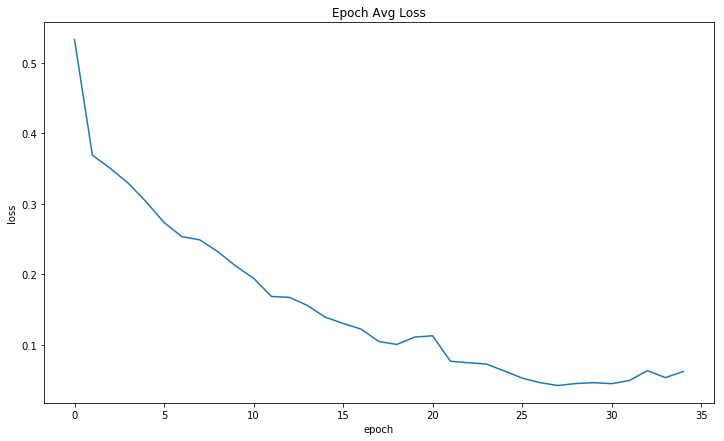

In [60]:
f, ax = plt.subplots(figsize=(12, 7))
plt.plot(list(np.arange(len(epoch_avg_losses))), epoch_avg_losses)
plt.title('Epoch Avg Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [96]:
i = 3
sentence = df.iloc[X_train.iloc[:100].index[i]].slang
target = df.iloc[y_train.iloc[:100].index[i]].formal
print(sentence)
input_tensor = to_torch(pd.Series([encoded_from_sentence(sentence, max_len_slang)]))[0]
output_tensor = to_torch(pd.Series([encoded_from_sentence(target, max_len_slang)]))[0]
train(input_tensor, output_tensor, e, d, eoptimizer, doptimizer, criterion)
out, attn = evaluate(e, d, input_tensor)
print(decoded_to_sentence(out))
# print()

bngt
bangga


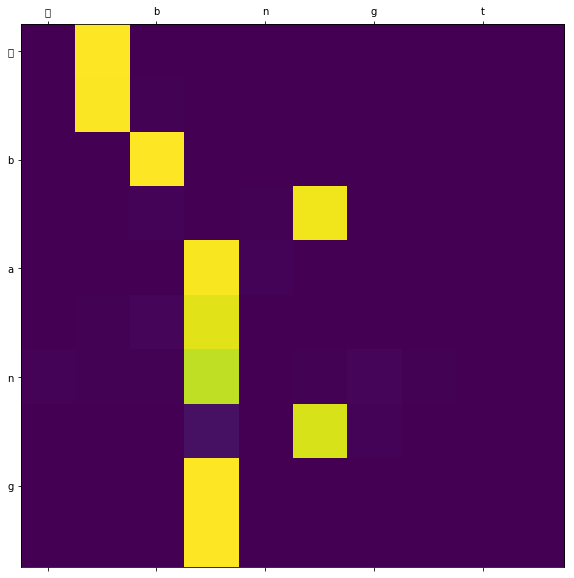

In [100]:
max_len = 10
npinput = input_tensor.numpy()[:max_len]
npout = out[:max_len]
npattn = attn.numpy()[:max_len,:max_len]
xlen, ylen = npattn.shape

f, ax = plt.subplots(figsize=(12, 10))
ax.matshow(npattn)
ax.set_xticklabels(['*'] + [chr(x) for x in npinput] + ['*'])
ax.set_yticklabels(['*'] + [chr(x) for x in npout] + ['*'])
plt.show()

In [132]:
df_wt_prediction = df.iloc[X_train.iloc[:200].index]
df_wt_prediction['predicted_formal'] = df_wt_prediction['slang'].apply(
    lambda slang: evaluate_sentence(e, d, slang).replace(chr(1), '')
)

/home/arie/miniconda2/envs/data_analysis_351/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [133]:
from sklearn.metrics import accuracy_score

print('accuracy: {}'.format(
    accuracy_score(df_wt_prediction['formal'],  
                   df_wt_prediction['predicted_formal']))
)


accuracy: 0.56


In [134]:
# df_wt_prediction = df.iloc[X_train.iloc[:100].index]
# df_wt_prediction['predicted_formal'] = df_wt_prediction['slang'].apply(
#     lambda slang: evaluate_sentence(e, d, slang).replace(chr(1), '')
# )
print('accuracy: {}'.format(accuracy_score(df_wt_prediction['formal'],  df_wt_prediction['predicted_formal'])))

accuracy: 0.56


In [135]:
df_wt_correct_prediction = df_wt_prediction[
    df_wt_prediction.formal == df_wt_prediction.predicted_formal
]

In [136]:
import altair as alt

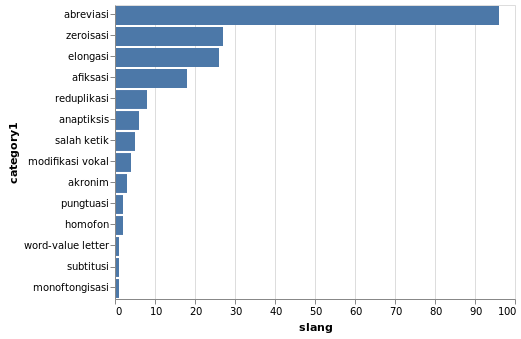

In [137]:
agg_all = df_wt_prediction.groupby(
    'category1'
).agg('count')['slang'].reset_index()
alt.Chart(agg_all).mark_bar().encode(
    x='slang',
    y=alt.Y(
        'category1',
        sort=alt.EncodingSortField(
            field='slang',
            op='sum',
            order='descending'
        )
    )
)

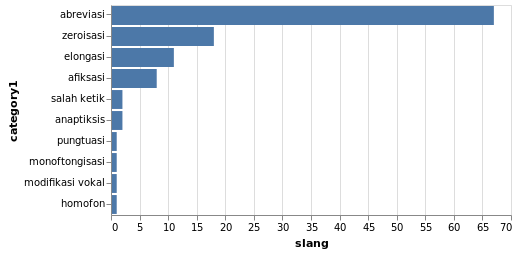

In [138]:
agg = df_wt_correct_prediction.groupby(
    'category1'
).agg('count')['slang']
agg = agg.reset_index()
alt.Chart(agg).mark_bar().encode(
    x='slang',
    y=alt.Y(
        'category1',
        sort=alt.EncodingSortField(
            field='slang',
            op='sum',
            order='descending'
        )
    )
)

In [139]:
all_vs_correct_prediction = pd.merge(
    agg_all, agg.rename(
        index=str, columns={
        'category1': 'correct_pred_category1', 
        'slang': 'correct_pred_slang'
    })
, left_on='category1', right_on='correct_pred_category1', how='left').fillna(0)
all_vs_correct_prediction['correct_pct'] = all_vs_correct_prediction[
    'correct_pred_slang'
] / all_vs_correct_prediction['slang']

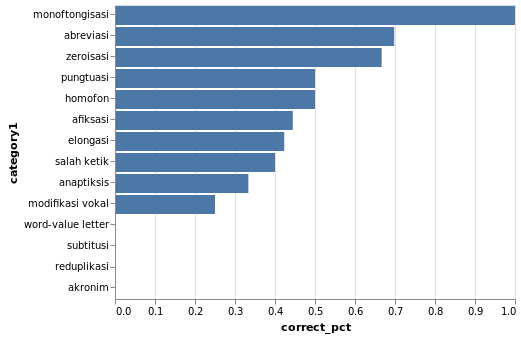

In [140]:
alt.Chart(all_vs_correct_prediction).mark_bar().encode(
    x='correct_pct:Q',
    y=alt.Y(
        'category1:N'
        , sort=alt.EncodingSortField(
            field='correct_pct',
            op='sum',
            order='descending'
        )
    )
)

In [148]:
df_wt_prediction.iloc[150:170]

,slang,formal,In-dictionary,context,category1,category2,category3,predicted_formal
7215,sihh,sih,1,@meilisa_kyungsoo_ hahaha knpa MBA?hidup MBA d...,elongasi,0,0,susih
6918,ka,kak,1,Kamu sepupunya ka raka ya,zeroisasi,0,0,kakak
10826,rame2,rame-rame,0,Gue ada tiket nobar film winter in tokyo. Sisa...,reduplikasi,0,0,rarang
1507,ngelawak,melawak,1,"Senang itu ketika ngelihat bang andre, sule, p...",afiksasi,0,0,melahirkan
1254,tuhh,tuh,0,DULU AKU SAMPAI GK PERCAYA SAMA PRODUKNYA@QUEE...,elongasi,0,0,tuh
7800,yah,ya,1,luar biasa yah ka masker jerawat yang pernah k...,anaptiksis,0,0,yaa
14499,pnting,penting,1,Pede males amat minta foto ama u ga ada krjaan...,abreviasi,0,0,puntengan
3774,yg,yang,1,Ka @marcelchandra yg tatto dan ka @mischach y...,abreviasi,0,0,yang
4580,bangeet,banget,1,Romantis bangeet siiihhh miaw @mia_fitcoach #m...,elongasi,0,0,bengetan
979,beginiiii,begini,1,dari dlu belum kesampean poto kayak beginiiii....,elongasi,0,0,bengen
